In [1]:
#import packages
#pip install textblob
#pip install keras
#pip install tensorflow
from textblob import TextBlob
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

2023-04-24 11:21:05.836251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [135]:
year = "2010"
file_path = "/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/"
file_path_2 = "_final_rnn.pickle"

df_10= pd.read_pickle(file_path + year + file_path_2)

In [136]:
def absolute_count(male_col, female_col):
    if female_col > male_col and male_col == 0:
        return 1
    elif male_col> female_col and female_col ==0: 
        return 0
    else: 
        return None

#PP Data
df_10['col_type'] = df_10.apply(lambda row: absolute_count(row['male_count'], row['female_count']),axis=1)
df_10 = df_10[df_10["col_type"].notnull()]

In [68]:
def subjectivity(sentence):
    subjectivity = ""

    subjectivity = TextBlob(sentence).sentiment.subjectivity

    return subjectivity

def polarity(sentence):
    polarity = ""
    polarity = TextBlob(sentence).sentiment.polarity
    return polarity

In [137]:
df_10['subjectivity'] = df_10['string_rnn'].apply(subjectivity)
df_10['polarity'] = df_10['string_rnn'].apply(polarity)

In [138]:
df_10

,pre_processed_sent,string_rnn,male_count,female_count,Proper_noun_list,pn exists,sentences,article_id,year,col_type,subjectivity,polarity
0,"[say, delight, restored, bridge, back, use]",say delight restored bridge back use,1,0,[Southease],None,"Chairman of Southease Parish, Neville Harrison...",1,2010,0.0,0.000000,0.000000
1,"[family, year, old, kill, house, fire, pay, tr...",family year old kill house fire pay tribute br...,0,2,[],None,The family of a 34-year-old mother from Bristo...,21,2010,1.0,0.200000,0.100000
3,"[truly, tragic, love, family, everything, give...",truly tragic love family everything give famil...,0,4,[Sara],None,"'Truly tragic'""Sara loved her family above eve...",21,2010,1.0,0.650000,0.083333
4,"[everybody, know, love, miss, always]",everybody know love miss always,0,3,[],None,"""Everybody who knew her will love her and miss...",21,2010,1.0,0.600000,0.500000
5,"[truly, tragic, event, keen, determine, exactl...",truly tragic event keen determine exactly lead...,0,1,[],None,"""This was a truly tragic event and we are very...",21,2010,1.0,0.466667,-0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...
514542,"[contrast, news, conference, sound, guard, eve...",contrast news conference sound guard even slig...,2,0,[Fabio],None,Compare and contrast - Fabio Capello's news co...,2175804,2010,0.0,0.368889,0.131111
514543,"[goal, one, chosen, five, could, take, spot, k...",goal one chosen five could take spot kick need,2,0,"[Nelson, Mandela]",True,And after his goal at the Nelson Mandela Bay S...,2175804,2010,0.0,0.000000,0.000000
514544,"[everyone, practise, say]",everyone practise say,1,0,[],None,"""Everyone has been practising them,"" he said.",2175804,2010,0.0,0.000000,0.000000
514545,"[look, relax, hair, back, cornrows, mobile, tu...",look relax hair back cornrows mobile tuck righ...,4,0,[],None,"He looked relaxed, his hair back in cornrows, ...",2175804,2010,0.0,0.345238,0.095238


In [85]:
def scores(df, col): 
    sub = []
    pol = []
    count = 0
    for index, row in df.iterrows():
        if row[col] > 1: 
            sub.append(row["subjectivity"])
            pol.append(row["polarity"])
        count +=1
    return ((sum(sub))/count), ((sum(pol))/count)
        

**Results** 

*Subjectivity* - how subjective or objective a piece of text is. 0.0 is most objective and 1.0 is more subjective. 0.5 is a neutral score. 

*Polarity* - how positive or negative a piece of text is. -1 is most negative and 1 most positive. 


In [139]:
#scores MEN 
scores_sent_m = scores(df_10, 'male_count')
subjectivity_m = round(scores_sent_m[0], 4) #subjectivity
polarity_m = round(scores_sent_m[1], 4) #polarity
print(subjectivity_m)
print(polarity_m)

0.0602
0.0105


In [140]:
#scores for women
scores_sent_f = scores(df_10, 'female_count')
subjectivity_f = round(scores_sent_f[0], 4) #subjectivity
polarity_f = round(scores_sent_f[1], 4) #polarity
print(subjectivity_f)
print(polarity_f)

0.0196
0.0036


In [144]:
#polarity and sentiment scores for F and M by year
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
sub_male = [0.0602, 0.0585, 0.0605, 0.0605, 0.0608, 0.0621, 0.0613, 0.0586, 0.0583, 0.0588, 0.0573, 0.0566, 0.0567]
pol_male = [0.0105, 0.0101, 0.0109, 0.0105, 0.0112, 0.0111, 0.0117, 0.0098, 0.0096, 0.009, 0.0102, 0.0102, 0.0096]
sub_female = [0.0196, 0.02, 0.0196, 0.0209, 0.0222, 0.0236, 0.0275, 0.0295, 0.032, 0.0317, 0.031, 0.034, 0.0354]
pol_female = [0.0036, 0.0037, 0.0042, 0.0041, 0.0041, 0.0048, 0.0058, 0.0059, 0.0061, 0.0059, 0.0061, 0.0065, 0.0075]

sent_data = {'Year': years, 
             'Subjectivity (M)': sub_male,
             'Polarity (M)': pol_male, 
             'Subjectivity (F)': sub_female, 
             'Polarity (F)': pol_female}

sent_data = pd.DataFrame(sent_data)
sent_data

,Year,Subjectivity (M),Polarity (M),Subjectivity (F),Polarity (F)
0,2010,0.0602,0.0105,0.0196,0.0036
1,2011,0.0585,0.0101,0.0200,0.0037
2,2012,0.0605,0.0109,0.0196,0.0042
3,2013,0.0605,0.0105,0.0209,0.0041
4,2014,0.0608,0.0112,0.0222,0.0041
5,2015,0.0621,0.0111,0.0236,0.0048
6,2016,0.0613,0.0117,0.0275,0.0058
7,2017,0.0586,0.0098,0.0295,0.0059
8,2018,0.0583,0.0096,0.0320,0.0061
9,2019,0.0588,0.0090,0.0317,0.0059


**EDA Yearly Sentiment**

In [163]:
sent_data[['Year', 'Subjectivity (M)', 'Subjectivity (F)']]

,Year,Subjectivity (M),Subjectivity (F)
0,2010,0.0602,0.0196
1,2011,0.0585,0.0200
2,2012,0.0605,0.0196
3,2013,0.0605,0.0209
4,2014,0.0608,0.0222
5,2015,0.0621,0.0236
6,2016,0.0613,0.0275
7,2017,0.0586,0.0295
8,2018,0.0583,0.0320
9,2019,0.0588,0.0317


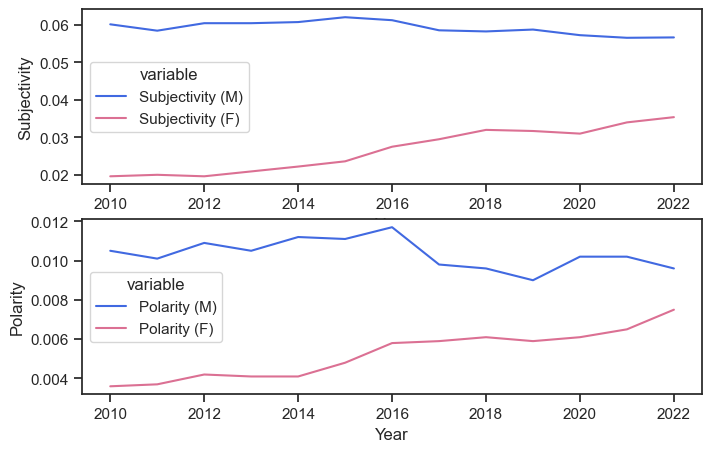

In [195]:
sub = sent_data[['Year', 'Subjectivity (M)', 'Subjectivity (F)']]
pola = sent_data[['Year','Polarity (M)', 'Polarity (F)']]

sns.set_theme(style='ticks')
fig, axis = plt.subplots(nrows =2, figsize = (8,5))
ax = sns.lineplot(x='Year', y='value', hue='variable', 
             data=pd.melt(sub, ['Year']),
             palette=['royalblue', 'palevioletred'], ax = axis[0])

ax.set(xlabel = "Year", ylabel = "Subjectivity")
ax = sns.lineplot(x='Year', y='value', hue='variable', 
             data=pd.melt(pola, ['Year']),
             palette=['royalblue', 'palevioletred'], ax = axis[1])

ax.set(xlabel = "Year", ylabel = "Polarity")
plt.show()

**Decade Model**

In [ ]:
#df_all = pd.concat([df_10, df_11, df_12, df_13, df_14, df_15, df_16, df_17, df_18, df_19, df_20, df_21, df_22])
#df_all

**Table Comparing Model Results**

In [ ]:
results = {' ': ['LSTM', 'CNN'],
           'Accuracy': [0.638, 0.926],
           'Mean Squared Error': [0.193, 0.0605],
           'Test loss': [0.65, 0.223]}

# Create a pandas dataframe from the dictionary
df = pd.DataFrame(results)

# Set the index of the dataframe to the Kernel column
df.set_index(' ', inplace=True)

# Display the dataframe
print(df)